In [216]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from tqdm import tqdm

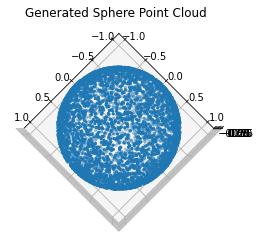

In [5]:
def generate_sphere_point_cloud(num_points, radius=1):
    phi = torch.rand(num_points) * 2 * torch.pi
    theta = torch.acos(2 * torch.rand(num_points) - 1)

    x = radius * torch.sin(theta) * torch.cos(phi)
    y = radius * torch.sin(theta) * torch.sin(phi)
    z = radius * torch.cos(theta)

    return torch.stack((x, y, z), dim=1)

# Parameters
n_samples = 5000

# Generate a sphere point cloud with 5000 points and radius 1
sphere_cloud = generate_sphere_point_cloud(n_samples, radius=1)


# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sphere_cloud[:, 0], sphere_cloud[:, 1], sphere_cloud[:, 2], s=5)
ax.set_aspect('equal')
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(90, 40)
plt.show()

In [308]:
def exp_map_manifold(point_cloud, p, v, k = 500):
    #p: (n-array) the initial point p in the point cloud   v: (n-array) the dirctional vector 
    #k: number of neighbors used for finding best transported point
    
    nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(point_cloud)  
    dist, p_new_index = nbrs.kneighbors(p + v)
    q = point_cloud[p_new_index[:, 0]]
    
    return q

def list_vector_of_index(set_vectors, list_indices):
    
    list_result_vectors = [np.array([set_vectors[i] for i in list_indices[j]]) for j in range(len(list_indices))]
    
    return list_result_vectors

In [165]:
p = sphere_cloud[0: 2]
v = sphere_cloud[2:4]

In [166]:
q = p + v

In [177]:
parallel_transport_manifold(point_cloud, v, p, q, stalk_dim = 2, k = 500, epsilon_PCA = 0.2)

tensor([[ 0.1682, -0.2856,  0.2246],
        [ 0.1733, -0.3925, -0.4903]], dtype=torch.float64)

In [188]:
def parallel_transport_manifold(point_cloud, v, p, q, stalk_dim = 2, k = 500, epsilon_PCA = 0.2):
    out = []
    for i in range(p.shape[0]):
        
        nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(point_cloud) 
        #compute basis at p
        dist_p, p_nbrs_index = nbrs.kneighbors(p[i].reshape(1, -1))
        x_N_p = point_cloud[p_nbrs_index][1:]
        X_i_p = x_N_p - p[i]
        D_i_p = np.diag(np.sqrt(np.exp( - 5 * np.array(dist_p[0][1:]) ** 2 / epsilon_PCA)))
        U_p, S_p, VT_p = np.linalg.svd(X_i_p.T @ D_i_p, full_matrices = False)
        O_p = U_p[:, :stalk_dim]
    
        #compute basis at q
        dist_q, q_nbrs_index = nbrs.kneighbors(np.expand_dims(q[i], axis = 0))
        x_N_q = point_cloud[q_nbrs_index][1:]
        X_i_q = x_N_q - q[i]
        D_i_q = np.diag(np.sqrt(np.exp( - 5 * np.array(dist_q[0][1:]) ** 2 / epsilon_PCA)))
        U_q, S_q, VT_q = np.linalg.svd(X_i_q.T @ D_i_q, full_matrices = False)
        O_q = U_q[:, :stalk_dim]
    
        #compute parallel transport
        U, S, VT = np.linalg.svd(O_p.T @ O_q, full_matrices = False)
        O_pq = U @ VT #this is a matrix of 2 x 2
    
        #transport the vector v to at point q
        v_0 = np.array([np.dot(v[i], O_p.T[0]), np.dot(v[i], O_p.T[1])])
        v_q = O_pq @ v_0
        v_q = v_q[0] * O_q.T[0] + v_q[1] * O_q.T[1]  #change it to the vector form of coord (x, y, z)
        out.append(torch.from_numpy(v_q))
        
    result = torch.stack(out)
    
    return result

In [183]:

p = sphere_cloud[0]
q = sphere_cloud[1]
p

tensor([ 0.6280, -0.3875,  0.6749])

In [93]:
a = exp_map_manifold(sphere_cloud, p, q)

In [94]:
nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(sphere_cloud) 
    #compute basis at p
dist_p, p_nbrs_index = nbrs.kneighbors(p.reshape(1, -1))

In [112]:
b = parallel_transport_manifold(sphere_cloud, v, p, q).to(dtype=None)

In [203]:
c = np.array([[1, 1, 1], [4, 5, 6]])
np.linalg.norm(c, axis = -1)

array([1.73205081, 8.77496439])

In [297]:
x0.reshape(1, -1) + shooting_vec

TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.

In [317]:
class Geonet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(1,hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim,hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim,hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, input_dim))
    
    def forward(self, t):
        """
        x0 : N x d
        x1 : N x d
        t : T

        output : T x N x d
        """
        #avg = t * self.x1 + (1-t) * self.x0
        #enveloppe = self.scale_factor * (1- (t*2-1)**2)
        #outs =  self.mod(t) * enveloppe + avg
        #next_point = exp_map_manifold(self.point_cloud, self.net(t)[:imput_dim], self.net(t)[imput_dim: 2 * input_dim], k = self.k)
        #next_vector = parallel_transport_manifold(self.point_cloud, self.net(t)[imput_dim: 2 * input_dim], self.net(t)[:imput_dim], next_point, stalk_dim = self.stalk_dim, k = self.k, epsilon_PCA = 0.2)
        return self.net(t)
        #return torch.cat([next_point, next_vector.reshape(1, -1)])

In [318]:
dim = 3
hidden_dim = 16
x0 = sphere_cloud[0].detach().numpy()
x1 = sphere_cloud[1].detach().numpy()
point_cloud = sphere_cloud
t = torch.linspace(0,1,100)[:,None]
np.linalg.norm(x1-x0)

1.5065193

In [300]:
np.linspace(0, 1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [ ]:
v_and_ratio = curve(t).detach().numpy()
v = v_and_ratio[:, :dim]
    norm_v = np.linalg.norm(v, axis = -1)
    normallized_v = v/norm_v.reshape(-1, 1)
    ratio = (1 + v_and_ratio[:, dim]).reshape(-1, 1)
    
    shooting_vec = (t * normallized_v * np.linalg.norm(x1-x0)* ratio).detach().numpy()

In [319]:
curve = Geonet(dim, hidden_dim)

optimizer = torch.optim.Adam(curve.parameters(), lr=0.001)

In [314]:
batch_size = 256
losses = []
K = 200
N = 100
t = torch.linspace(0,1,N)[:,None]
for _ in tqdm(range(100)):

    optimizer.zero_grad()
    #t = torch.rand((batch_size,1))
    out = curve(t).detach().numpy()
    next_point = exp_map_manifold(point_cloud, out[:, :dim], out[:, dim: 2 * dim], k = K)
    next_vector = parallel_transport_manifold(point_cloud, out[:, dim: 2 * dim], out[:, :dim], next_point, stalk_dim = dim -1, k = K, epsilon_PCA = 0.2)
    error_v = out[1:, dim: 2 * dim] - next_vector[:N -1].detach().numpy()
    loss1 = sum(np.linalg.norm(error_v, axis = -1))
    loss2 = np.linalg.norm(out[0, :dim]- x0)
    loss3 = np.linalg.norm(out[N-1, :dim]- x1)

    loss = loss1/N + loss2 + loss3
    loss = torch.tensor(loss, requires_grad=True)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().numpy())

100%|██████████| 100/100 [00:34<00:00,  2.94it/s]


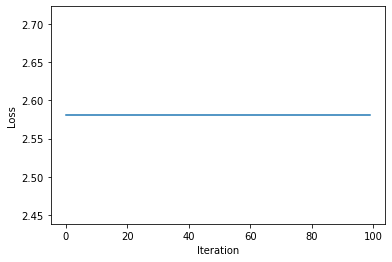

In [315]:
plt.figure()
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

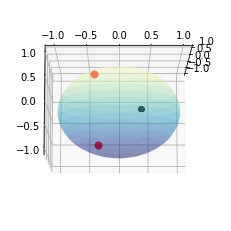

In [316]:
out = curve(t).detach().numpy()
out = out[:, :dim]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(out[:, 0], out[:, 1], out[:,2], c= 'black')
ax.scatter(x0[0], x0[1], x0[2], s = 50, c = 'r')
ax.scatter(x1[0], x1[1], x1[2], s = 50, c = 'r')

u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r, alpha=0.3)
ax.view_init(-10, 0)
plt.show()